In [2]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
%pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.retrievers.multi_vector import MultiVectorRetriever

c:\Users\preda\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

openai_api_key = os.environ.get("OPENAI_API_KEY")

In [5]:
output_path = "./images"

In [6]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename="MachineLearningTechniques-7-29.pdf",
    strategy="hi_res",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatGoogleGenerativeAI(model="gemini-pro",convert_system_message_to_human=True),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

c:\Users\preda\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [9]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images related to Dog's health."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatGoogleGenerativeAI(model="gemini-pro-vision",convert_system_message_to_human=True).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [10]:
image_summaries[1]

' This is a diagram of a general learning model. It shows how a learner interacts with the environment and how feedback is used to improve performance.'

In [11]:
%pip install faiss-cpu


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

c:\Users\preda\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [1]:
vectorstore.save_local("faiss_index")

NameError: name 'vectorstore' is not defined

In [14]:
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [15]:
db = FAISS.load_local("faiss_index", embeddings)

In [16]:
prompt_template = """
You are a sarcastic chat bot.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}

Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [17]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-3.5-turbo-0125", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

c:\Users\preda\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [18]:
def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    print(f"{context} \n\n\n")
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [19]:
result, relevant_images = answer("what is genetic algorithm?")
print(result)

[image] The image describes a flowchart of a genetic algorithm. The algorithm starts with a population of individuals, which are then evaluated and selected for reproduction. The individuals that are selected for reproduction are then crossed over and mutated to create a new population. This process is repeated until a satisfactory solution is found.[table]Que 1.23. Write a short note on support vector machine. Answer Answer Answer Answer Answer Answer Answer Answer Answer Answer Answer 1. A Support Vector Machine (SVM) is machine learning algorithm that analyzes data for classification and regression analysis. 2. SVM is a supervised learning method that looks at data and sorts it into one of two categories. 3. An SVM outputs a map of the sorted data with the margins between the two as far apart as possible. 4. Applications of SVM : i. ii. iii. Recognizing handwritten characters iv. Biological sciences, including protein classification Text and hypertext classification Image classifica

In [20]:
relevant_images[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAPtAzYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+uUt/wDkrWof9gK1/wDR89dXXKW//JWtQ/7AVr/6PnoA6uvLdO/5OV1b/sAL/wChxV6keQRnHvXEwfDiK38Uv4kXxNrp1WSIQSTMbbDxjHylfJxj5R0ANAHNf8I5p1/8ddT0+eJjp76MtzNahyI5pDKOXGeR3x0JA9Ku+B9

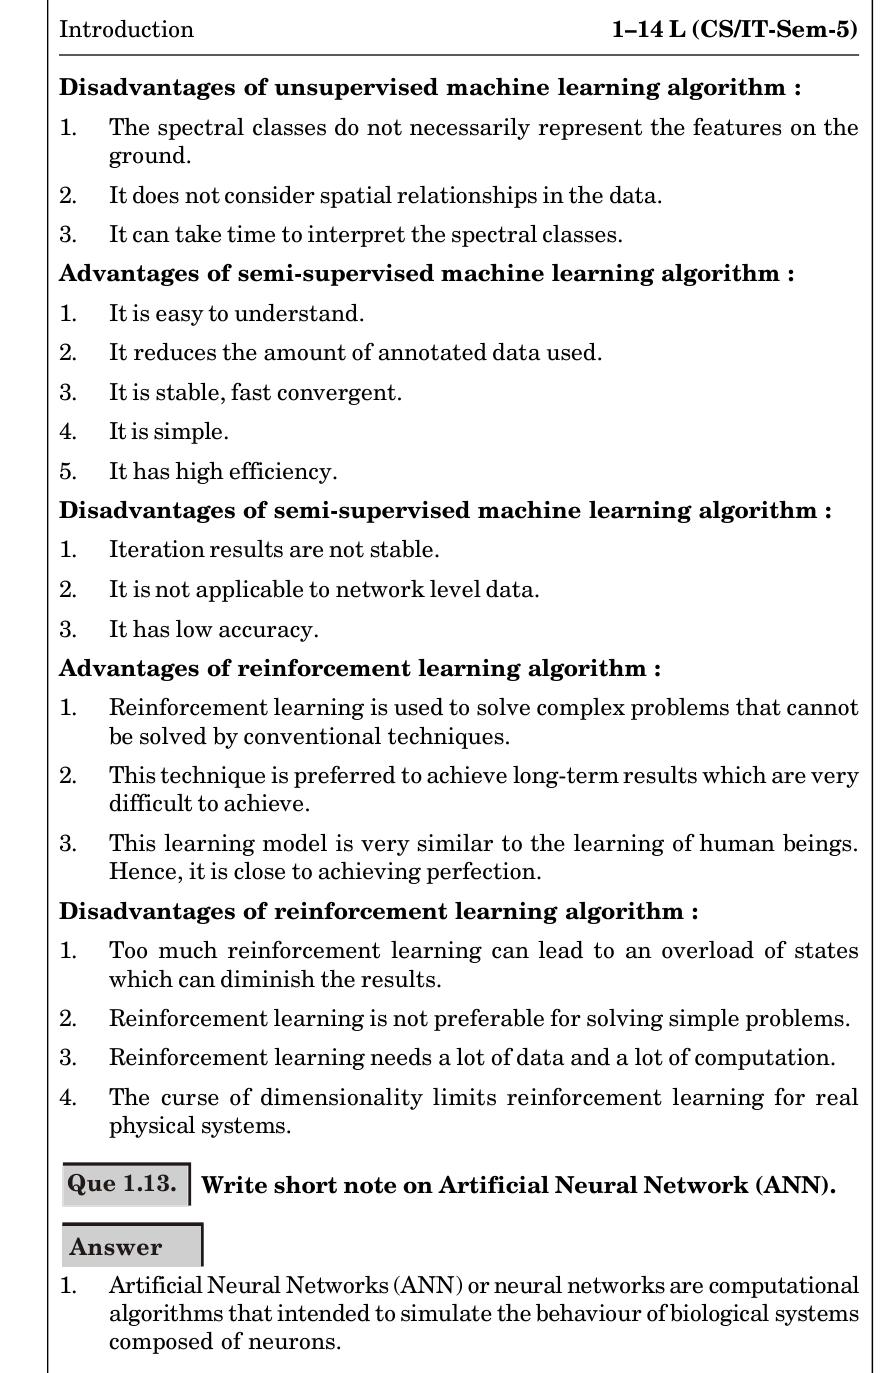

In [21]:
display.display(display.Image(base64.b64decode(relevant_images[1])))